# Comparison between Neuroprobe Lite and Neuroprobe Nano
This notebook investigates whether Neuroprobe Nano and Lite give similar results when evaluating a suite of models (here, logistic regression on top of STFT for varying values of nperseg and noverlap). The comparison is done across all subjects and trials in the Neuroprobe Lite / Nano.

To reproduce the analysis, first you will need to run run_scripts/analysis_input_representation_lite and _nano (those are made for SBATCH, for running in parallel). Then, run all the cells in this notebook!

In [4]:
import torch
import neuroprobe.config as neuroprobe_config
from neuroprobe.braintreebank_subject import BrainTreebankSubject
from neuroprobe.datasets import BrainTreebankSubjectTrialBenchmarkDataset
import numpy as np
import json, os

def load_results(dirname, subject_trials):
    results_array = np.zeros((len(subject_trials), len(neuroprobe_config.NEUROPROBE_TASKS)))
    times_array = np.zeros((len(subject_trials), len(neuroprobe_config.NEUROPROBE_TASKS), 2))
    for st_i, (subject_id, trial_id) in enumerate(subject_trials):
        for t_i, task_name in enumerate(neuroprobe_config.NEUROPROBE_TASKS):
            results_path = os.path.join(dirname, f"population_btbank{subject_id}_{trial_id}_{task_name}.json")
            with open(results_path, "r") as f:
                results = json.load(f)
                eval_results = results["evaluation_results"][f"btbank{subject_id}_{trial_id}"]["population"]["one_second_after_onset"]
                eval_results = np.mean([fold["test_roc_auc"] for fold in eval_results["folds"]])

                times_array[st_i, t_i, 0] = results["timing"]["subject_load_time"]
                times_array[st_i, t_i, 1] = results["timing"]["regression_run_time"]
            results_array[st_i, t_i] = eval_results
    return results_array, times_array

# noverlap: 0%, 25%, 50%, 75%, 87.5%, 93.75%
# nperseg: 400, 512, 256, 128
poverlap_options = [0.0, 0.25, 0.5, 0.75, 0.875]#, 0.9375]
nperseg_options = [128, 256, 400, 512]

NEUROPROBE_NANO_RESULTS = np.zeros((len(neuroprobe_config.NEUROPROBE_NANO_SUBJECT_TRIALS),
                                    len(neuroprobe_config.NEUROPROBE_TASKS),
                                    len(poverlap_options), len(nperseg_options)))
NEUROPROBE_NANO_TIMES = np.zeros((len(neuroprobe_config.NEUROPROBE_NANO_SUBJECT_TRIALS),
                                    len(neuroprobe_config.NEUROPROBE_TASKS),
                                    len(poverlap_options), len(nperseg_options), 2))

NEUROPROBE_LITE_RESULTS = np.zeros((len(neuroprobe_config.NEUROPROBE_NANO_SUBJECT_TRIALS),
                                    len(neuroprobe_config.NEUROPROBE_TASKS),
                                    len(poverlap_options), len(nperseg_options)))
NEUROPROBE_LITE_TIMES = np.zeros((len(neuroprobe_config.NEUROPROBE_NANO_SUBJECT_TRIALS),
                                    len(neuroprobe_config.NEUROPROBE_TASKS),
                                    len(poverlap_options), len(nperseg_options), 2))

NEUROPROBE_LITE_RESULTS_ALL_ST = np.zeros((len(neuroprobe_config.NEUROPROBE_LITE_SUBJECT_TRIALS),
                                    len(neuroprobe_config.NEUROPROBE_TASKS),
                                    len(poverlap_options), len(nperseg_options)))

for poverlap_i, poverlap in enumerate(poverlap_options):
    for nperseg_i, nperseg in enumerate(nperseg_options):
        results_array, times_array = load_results(f"data/analyses/input_representation/eval_results_nano_SS_SM/linear_stft_abs_nperseg{nperseg}_poverlap{poverlap}", neuroprobe_config.NEUROPROBE_NANO_SUBJECT_TRIALS)
        NEUROPROBE_NANO_RESULTS[:, :, poverlap_i, nperseg_i] = results_array
        NEUROPROBE_NANO_TIMES[:, :, poverlap_i, nperseg_i] = times_array

        results_array, times_array = load_results(f"data/analyses/input_representation/eval_results_lite_SS_SM/linear_stft_abs_nperseg{nperseg}_poverlap{poverlap}", neuroprobe_config.NEUROPROBE_NANO_SUBJECT_TRIALS)
        NEUROPROBE_LITE_RESULTS[:, :, poverlap_i, nperseg_i] = results_array
        NEUROPROBE_LITE_TIMES[:, :, poverlap_i, nperseg_i] = times_array

        results_array, times_array = load_results(f"data/analyses/input_representation/eval_results_lite_SS_SM/linear_stft_abs_nperseg{nperseg}_poverlap{poverlap}", neuroprobe_config.NEUROPROBE_LITE_SUBJECT_TRIALS)
        NEUROPROBE_LITE_RESULTS_ALL_ST[:, :, poverlap_i, nperseg_i] = results_array

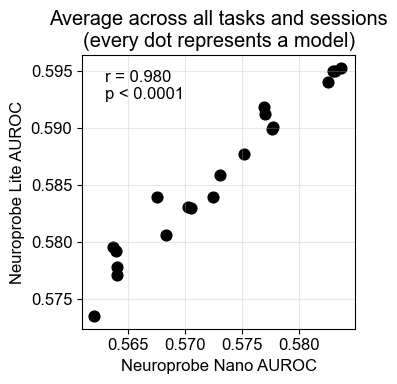

Correlation coefficient: 0.980
P-value: 5.5698419739175864e-14


In [66]:
import matplotlib.pyplot as plt
# Add Arial font
import matplotlib.font_manager as fm
font_path = 'assets/font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})

# Flatten arrays to 1D for correlation plot
nano_flat = NEUROPROBE_NANO_RESULTS.mean(axis=0).mean(axis=0).flatten()
lite_flat = NEUROPROBE_LITE_RESULTS_ALL_ST.mean(axis=0).mean(axis=0).flatten()
# Calculate correlation coefficient and p-value
from scipy import stats
r, p = stats.pearsonr(nano_flat, lite_flat)

plt.figure(figsize=(4, 4))
plt.scatter(nano_flat, lite_flat, alpha=1, s=60, color='black')
# plt.plot([0.4, 0.7], [0.4, 0.7], 'k--', alpha=0.5) # Plot y=x line

plt.xlabel('Neuroprobe Nano AUROC')
plt.ylabel('Neuroprobe Lite AUROC') 
plt.title('Average across all tasks and sessions\n(every dot represents a model)')

# Add correlation text
plt.text(0.563, 0.5925, f'r = {r:.3f}\np < 0.0001', fontsize=12)

# Make axes equal and set limits
plt.axis('square')
# plt.xlim(0.4, 0.7)
# plt.ylim(0.4, 0.7)

plt.grid(True, alpha=0.3)
plt.tight_layout()
save_path = 'data/figures/nano_lite_comparison_models.pdf'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, bbox_inches='tight')
plt.show()

# Print correlation coefficient
print(f"Correlation coefficient: {r:.3f}")
print(f"P-value: {p}")


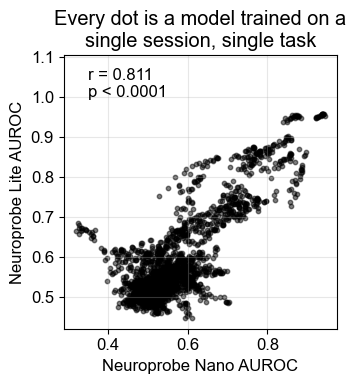

Correlation coefficient: 0.811
P-value: 0.0


In [67]:
import matplotlib.pyplot as plt
# Add Arial font
import matplotlib.font_manager as fm
font_path = 'assets/font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})

# Flatten arrays to 1D for correlation plot
nano_flat = NEUROPROBE_NANO_RESULTS.flatten()
lite_flat = NEUROPROBE_LITE_RESULTS.flatten()
# Calculate correlation coefficient and p-value
from scipy import stats
r, p = stats.pearsonr(nano_flat, lite_flat)

plt.figure(figsize=(4, 4))
plt.scatter(nano_flat, lite_flat, alpha=.5, s=10, color='black')
# plt.plot([0.4, 0.7], [0.4, 0.7], 'k--', alpha=0.5) # Plot y=x line

plt.xlabel('Neuroprobe Nano AUROC')
plt.ylabel('Neuroprobe Lite AUROC') 
plt.title('Every dot is a model trained on a\nsingle session, single task')

# Add correlation text
plt.text(0.35, 1.0, f'r = {r:.3f}\np < 0.0001', fontsize=12)

# Make axes equal and set limits
plt.axis('square')
# plt.xlim(0.4, 0.7)
# plt.ylim(0.4, 0.7)

plt.grid(True, alpha=0.3)
plt.tight_layout()
save_path = 'data/figures/nano_lite_comparison_all_tasks.pdf'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, bbox_inches='tight')
plt.show()

# Print correlation coefficient
print(f"Correlation coefficient: {r:.3f}")
print(f"P-value: {p}")


Saved figure to data/figures/nano_lite_comparison_time.pdf


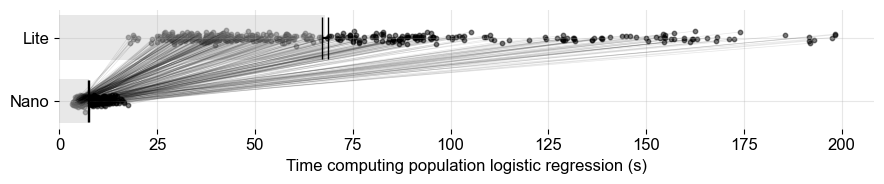

Mean Neuroprobe Nano time: 7.443s
Mean Neuroprobe Lite time: 67.903s


In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten time arrays and take mean across the two time measurements
nano_times_flat = NEUROPROBE_NANO_TIMES[:, :, :, :, 1].flatten()
lite_times_flat = NEUROPROBE_LITE_TIMES[:, :, :, :, 1].flatten()

plt.figure(figsize=(9, 2))

# Plot individual points and connecting lines
y = np.array([1, 1.5])
selected_indices = np.random.randint(0, len(nano_times_flat)-1, 400)
for i in selected_indices:
    # Add small random jitter to y positions
    jitter = np.random.normal(0, 0.02, 2)  # Generate 2 jitter values
    y_jittered = y + jitter
    
    plt.plot([nano_times_flat[i], lite_times_flat[i]], y_jittered,
             color='black', alpha=0.1, linewidth=0.5)
    plt.scatter([nano_times_flat[i]], [y_jittered[0]], color='black', alpha=0.5, s=10)
    plt.scatter([lite_times_flat[i]], [y_jittered[1]], color='black', alpha=0.5, s=10)

# Calculate means and standard errors for bars
nano_mean = np.mean(nano_times_flat)
lite_mean = np.mean(lite_times_flat)
nano_sem = np.std(nano_times_flat) / np.sqrt(len(nano_times_flat))
lite_sem = np.std(lite_times_flat) / np.sqrt(len(lite_times_flat))

# Plot bars with error bars
bar_height = 0.35
plt.barh(y, [nano_mean, lite_mean], height=bar_height, color=['lightgray', 'lightgray'],
         xerr=[[nano_sem, lite_sem]], capsize=15, alpha=0.5)

plt.yticks(y, ['Nano', 'Lite'])
plt.xlabel('Time computing population logistic regression (s)')
# plt.title('Processing Time Comparison')

# Remove axis borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)


# Add mean values to the right of bars
# plt.text(180, y[0], f'{nano_mean:.2f}s', ha='left', va='center')
# plt.text(180, y[1], f'{lite_mean:.2f}s', ha='left', va='center')

plt.grid(True, alpha=0.3)
plt.tight_layout()
save_path = 'data/figures/nano_lite_comparison_time.pdf'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, bbox_inches='tight')
print(f"Saved figure to {save_path}")
plt.show()

# Print mean times
print(f"Mean Neuroprobe Nano time: {nano_mean:.3f}s")
print(f"Mean Neuroprobe Lite time: {lite_mean:.3f}s")
